# Time Series and Forecasting Models: SARIMA

## 1. Introduction

The Seasonal Autoregressive Integrated Moving Average (SARIMA) model combines simpler models in order to capture moving averages throughout time series, taking into account trend, seasonality, and noise. 

We will build, train and test a SARIMA model for predicting AstraZeneca Adjusted Close price patterns.



## 2. Install/import libraries

In [ ]:
!pip install mplfinance
!pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from scipy import stats
from scipy.stats import zscore

from pmdarima.arima.utils import ndiffs

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from itertools import product
from tqdm.notebook import tqdm

import datetime
from datetime import date, timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 3. Import data

In [ ]:
ftse100_stocks = pd.read_pickle("ftse100_stocks.pkl")

ftse100_stocks

ULVR.L                       ...        BP.L                      
              Open         High     Low  ...       Close   Adj Close    Volume
Date                                     ...                                  
2010-01-04  1987.0  2006.000000  1981.0  ...  613.599976  323.723907  17956918
2010-01-05  1990.0  1997.000000  1942.0  ...  620.099976  327.153046  28352666
2010-01-06  1943.0  1955.000000  1935.0  ...  619.400024  326.783966  22054752
2010-01-07  1948.0  1961.000000  1926.0  ...  623.299988  328.841431  30630196
2010-01-08  1941.0  1948.000000  1917.0  ...  621.700012  327.997284  22458240
...            ...          ...     ...  ...         ...         ...       ...
2019-12-20  4351.5  4378.500000  4333.5  ...  485.049988  431.790558  88659433
2019-12-23  4382.0  4466.500000  4357.5  ...  489.049988  435.351318  44590108
2019-12-24  4409.0  4411.720215  4382.0  ...  487.700012  434.149597   6020955
2019-12-27  4395.5  4429.000000  4372.5  ...  483.950012  430.811340  24712316
2019-12-30  4426.0  4430.220215  4372.5  ...  478.500000  425.959747  35078105

[2518 rows x 36 columns]

In [ ]:
# Create DataFrame of AZN.L stock data

azn =  ftse100_stocks['AZN.L']
                                     
azn.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,2912.0,2946.0,2912.0,2941.0,1775.206909,2091679
2010-01-05,2936.0,2949.5,2901.0,2907.5,1754.986084,2869739
2010-01-06,2909.0,2909.0,2850.5,2875.0,1735.368652,3136541
2010-01-07,2879.0,2925.5,2879.0,2910.5,1756.796875,3748200
2010-01-08,2921.0,2927.5,2889.5,2908.5,1755.589600,2473846


In [ ]:
# Create DataFrame for Adjusted Close prices

azn_adj = azn[['Adj Close']]
azn_adj

,Adj Close
Date,
2010-01-04,1775.206909
2010-01-05,1754.986084
2010-01-06,1735.368652
2010-01-07,1756.796875
2010-01-08,1755.589600
...,...
2019-12-20,7592.499512
2019-12-23,7532.210938
2019-12-24,7501.093750


In [ ]:
# Plot Adjusted Close price

def azn_adj_plot():
  sns.set(rc={'figure.figsize':(16, 8)})
  azn_adj.plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

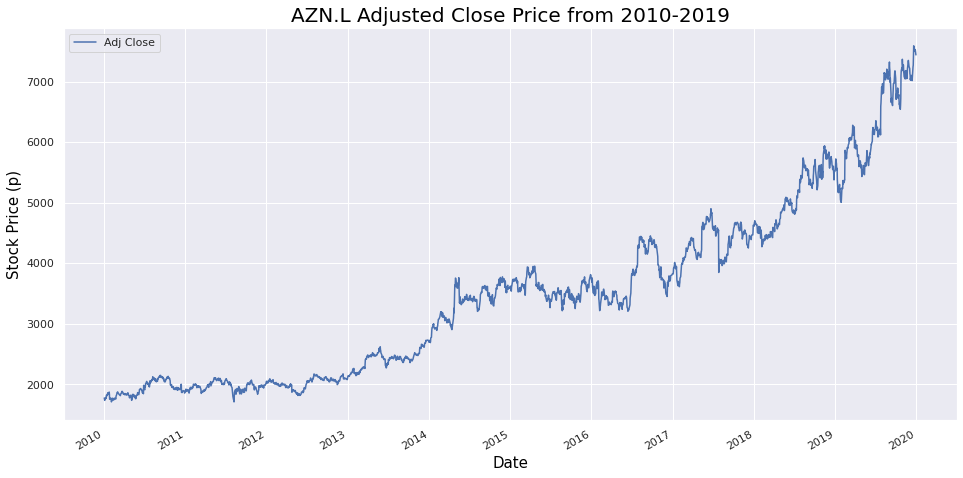

In [ ]:
title_txt = "AZN.L Adjusted Close Price from 2010-2019"
label_txt = "AZN.L Adj Close"

azn_adj_plot()

In [ ]:
#  Create DataFrame of Adjusted Close prices from the last 1000 periods

azn_adj_1000 = azn_adj[-1000:]

In [ ]:
# Plot last 1000 periods

def azn_adj_1000_plot():
  sns.set(rc={'figure.figsize':(16, 8)})
  azn_adj_1000.plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

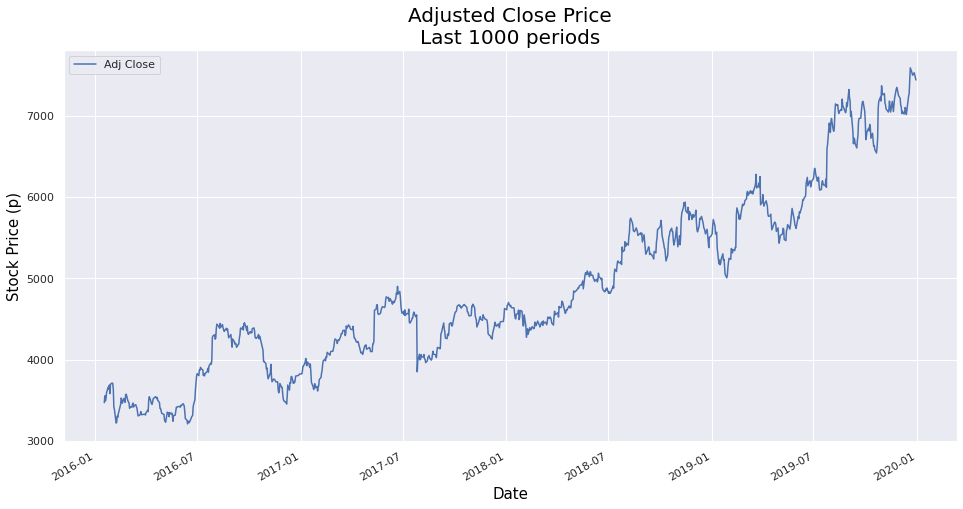

In [ ]:
title_txt = "Adjusted Close Price\nLast 1000 periods"
label_txt = "AZN.L Adj Close"

azn_adj_1000_plot()

## 4. Stationarity

Before modelling with SARIMA we must apply transformations to our time series to remove seasonality and any non-stationary behaviours.

### 4.1 Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

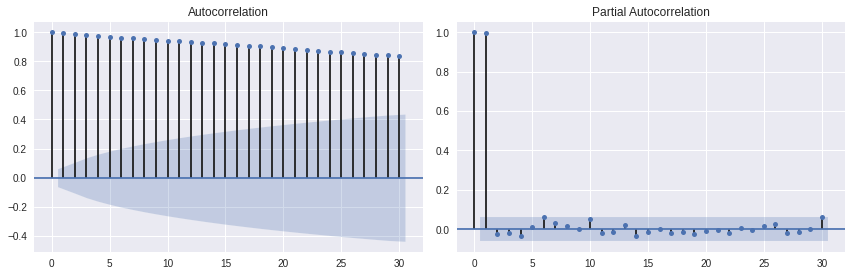

In [ ]:
# ACF and PACF for original non-differenced data

def acf_pacf_plot(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    acf_ax = plt.subplot2grid(layout, (0,0))
    pacf_ax = plt.subplot2grid(layout, (0,1))

    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
        
acf_pacf_plot(azn_adj_1000, lags=30)

There is clearly high autocorrelation. We will run an ADF test to further test for stationarity.

### 4.2 Augmented Dickey-Fuller (ADF) test

In [ ]:
# Check if price series is stationary
# Augmented Dickey-Fuller test

result = adfuller(azn_adj_1000.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -0.11914173373831236
p-value: 0.9474982505529123


The p-value is greater than the significance level of 0.05 so we cannot reject the null hypothesis that the process is not stationary. The next step is to determine the order of differencing required to make the series stationary.


### 4.3 Differencing

In [ ]:
# Detrend by first order differencing to achieve lower p-value

result = adfuller(azn_adj_1000.diff().dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -16.65378958001573
p-value: 1.5956760710236902e-29


The p-value is now much less than the significance level of 0.05 so the null hypothesis is rejected, and the process is considered to be stationary.

In [ ]:
# Create DataFrame of differenced prices

azn_adj_1000_diff = azn_adj_1000.diff().dropna()

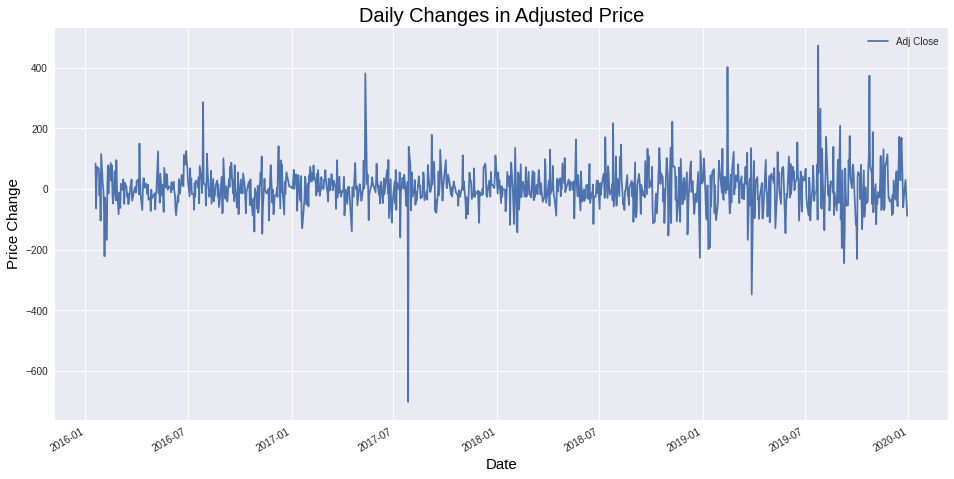

In [ ]:
# Plot returns

def returns_plot():
  plt.style.use('seaborn')
  azn_adj_1000_diff.plot(figsize=(16,8))
  plt.title("Daily Changes in Adjusted Price", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Price Change', color = 'black', fontsize = 15);
  plt.show()

returns_plot()

We can see that the returns randomly distribute around the mean of 0.

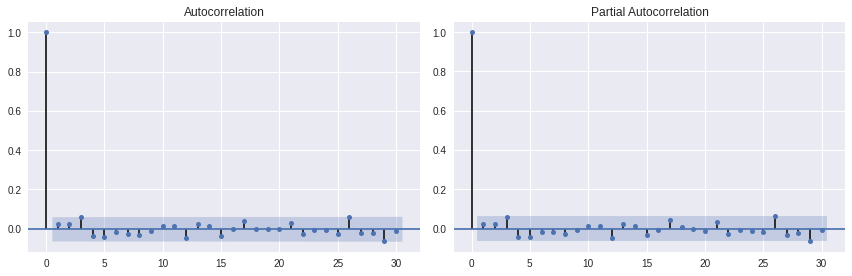

In [ ]:
# ACF and PACF for the differenced data

def acf_pacf_plot(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    acf_ax = plt.subplot2grid(layout, (0,0))
    pacf_ax = plt.subplot2grid(layout, (0,1))

    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
        
acf_pacf_plot(azn_adj_1000_diff, lags=30)

The plots above resemble those of white noise, therefore this model is ready to be used for forecasting.

## 5. Select parameters for modelling


A **SARIMA(p, d, q)(P, D, Q, s)** model takes the parameters: 
*   **AR(p)** from the Autoregression model representing the maximum lag,
*   **MA(q)** from the Moving Average model representing the biggest lag after which other lags are not significant on the ACF plot
*  The order of **Integration (d)** representing the number of
differences required to make the series stationary
* **Seasonality** in (P, D, Q, s) where **s** is the season's length, **P** and **Q** are the same as **p** and **q** but for the seasonal component, and **D** is the order of seasonal integration representing the number of differences required to remove seasonality from the series. 

A **SARIMAX** implementation is so-called because the **X** addition means that it also supports exogenous variables. This is an optional argument, rather than a parameter, for parallel time series variates made available as a weighted input to the model.

### 5.1 Grid search to select the best order for SARIMA model

In [ ]:
# Grid search function to iteratively explore different combinations of parameters

def best_param(model, data, pdq, pdqs):
    """
    Iterates through and runs model for all combinations for pdq and pdqs 
    to find model with lowest AIC score

    :param model: SARIMAX
    :param data: time series data 
    :param pdq: list with (p, d, q) tuples
    :param pdqs: list with (p, d, q, s) tuples 

    :returns: parameters and corresponding lowest AIC score
    """
    ans = []
    for comb in tqdm(pdq):
        for combs in tqdm(pdqs):
            try:
                mod = model(data,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df.aic.idxmin()]

### 5.2 Parameters to iterate through

In [ ]:
# Set initial values and some bounds for p, d, q.
p = d = q = range(0,5)
d = [1]

# Creating a list of all possible parameter combinations of p, d, q.
pdq = list(product(p, d, q))


# Add seasonal component to (p, d, q)
pdqs = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]


### 5.3 Search for optimum parameters

In [ ]:
# Finding best parameters for model

best_param(SARIMAX, azn_adj_1000, pdq, pdqs)

pdq         (0, 1, 4)
pdqs    (2, 1, 4, 12)
aic             10701
Name: 114, dtype: object

## 6. Modelling

### 6.1 Define training and test set

In [ ]:
# Split data into train and test set 

index = round(len(azn_adj_1000)*.80)

train = azn_adj_1000.iloc[:index]
test = azn_adj_1000.iloc[index:]

### 6.2 Fit and train the model

In [ ]:
# Fit best model to training data

model = SARIMAX(train, 
                order=(0, 1, 4), 
                seasonal_order=(2,1,4,12),
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

### Output summary of best model

In [ ]:
print(output.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                  800
Model:             SARIMAX(0, 1, 4)x(2, 1, 4, 12)   Log Likelihood               -4123.803
Date:                            Sun, 28 Mar 2021   AIC                           8269.606
Time:                                    15:43:55   BIC                           8320.190
Sample:                                         0   HQIC                          8289.117
                                            - 800                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0207      0.030      0.699      0.485      -0.037       0.079
ma.L2          0.0027      0.039   

We can see that the best performing model has both seasonal and non-seasonal moving average processes and seasonal autoregressive processes.

### Study the residuals

In [ ]:
# Ljung-Box test and Augmented Dickey-Fuller test 
ljung_box, p_value = acorr_ljungbox(output.resid)

print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: [0.96467256 1.09522824 1.29166026 1.54054389 1.54874773 1.56195168
 1.56310706 2.82555368 3.74585851 3.81148121]
p-value: [0.32601243 0.57832799 0.73111438 0.81943617 0.90737671 0.95527363
 0.98004413 0.9448233  0.92732936 0.95545089]


Looking at the p-values above, we can see that they are above 0.05, therefore we cannot reject the null hypothesis, and the residuals are are independent and not correlated.

### Plot residuals

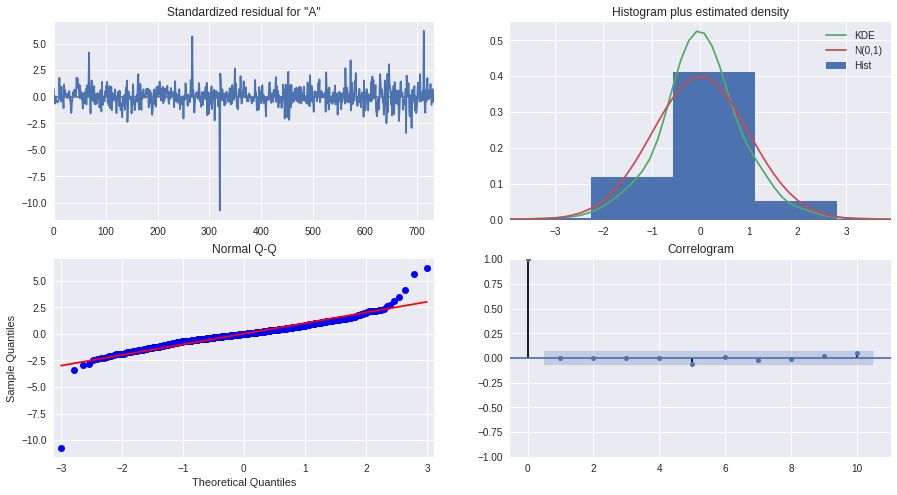

In [ ]:
output.plot_diagnostics(figsize=(15,8))
plt.show()

The correlogram, or ACF plot, shows no autocorrelation in the results as none are over the significance level and are just white noise. The normal Q-Q plot is almost straight suggesting no systematic departure from normality.

### 6.3 Test the model

In [ ]:
# Values to test against the test set
fc   = output.get_forecast(len(test))
conf = fc.conf_int()

# Transforming the values back to normal
fc_series    = pd.Series(fc.predicted_mean.values, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0].values, index=test.index)
upper_series = pd.Series(conf.iloc[:, 1].values, index=test.index)

# Values to test against the train set, see how the model fits
predictions = output.get_prediction(dynamic=False)
pred        = predictions.predicted_mean

# Confidence interval for the training set
conf_int   = predictions.conf_int()
low_conf   = pd.Series(conf_int.iloc[:,0], index=train.index)
upper_conf = pd.Series(conf_int.iloc[:,1], index=train.index)

### Plot train, test, predicted values and confidence interval

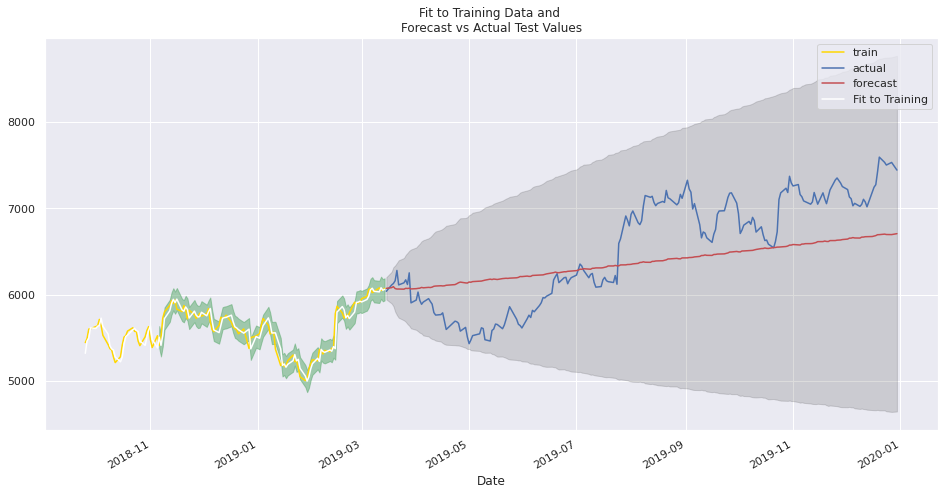

In [ ]:
sns.set(rc={'figure.figsize':(16, 8)})

# Plotting the training set, test set, forecast, and confidence interval.
plt.plot(train[-120:], label='train', color='gold')
plt.plot(test, label='actual', color='b')
plt.plot(fc_series, label='forecast', color='r')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Plotting against the training data
pred[-120:].plot(label='Fit to Training', color='w')

# Confidence interval for the fitted data
plt.fill_between(conf_int[-90:].index, conf_int[-90:].iloc[:,0], conf_int[-90:].iloc[:,1], color='g',alpha=.5)

plt.title('Fit to Training Data and \nForecast vs Actual Test Values')
plt.legend()
plt.show()

###  6.4 Evaluate the model

In [ ]:
# Calculate the RMSE

forecast = pred
actual_val = train['Adj Close']

# Calculating our errors
rmse = np.sqrt(((forecast - actual_val) ** 2).mean())

print("The Root Mean Squared Error: ", rmse)

The Root Mean Squared Error:  154.73383752964395


### 6.5 Predict future values 

In [ ]:
# Fitting and training with the entire dataset 


model = SARIMAX(azn_adj_1000, 
                order=(0, 1, 4), 
                seasonal_order=(2,1,4,12),
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

In [ ]:
# Getting the forecast of future values
future = output.get_forecast(steps=90)

# Predicted values
pred_fut = pd.Series(future.predicted_mean.values, 
                     index=pd.date_range(start=azn_adj_1000.index[-1]+datetime.timedelta(days=1), periods=90, freq="D"))

# Confidence interval for our forecasted values
pred_conf = pd.DataFrame(future.conf_int().values, 
                      index=pd.date_range(start=azn_adj_1000.index[-1]+datetime.timedelta(days=1), periods=90, freq="D"))

# Saving last daily prediction for later
d90 = pred_fut[-1]

### Plot the predicted values

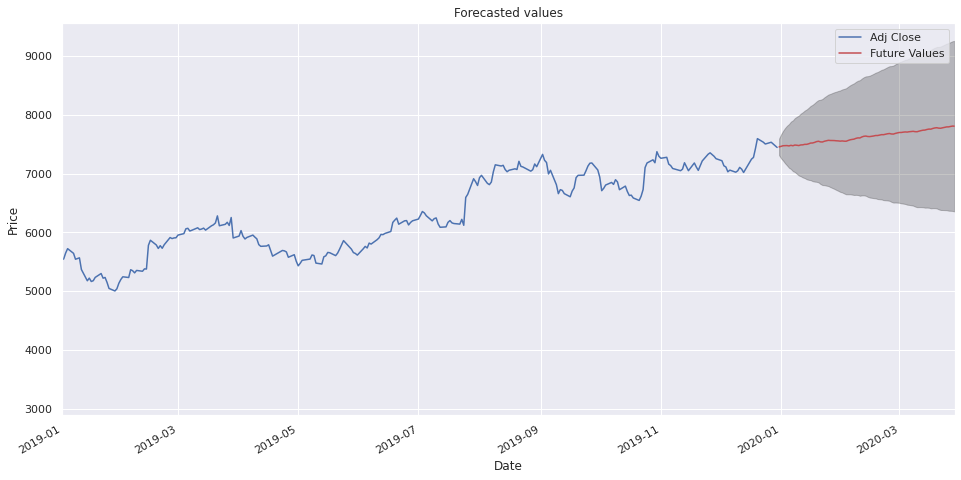

In [ ]:
# Plotting the prices up to the most recent
ax = azn_adj_1000.plot(label='Actual', figsize=(16,8))

# Plotting the forecast
pred_fut.plot(ax=ax, label='Future Values', color='r')

# Shading in the confidence interval
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.xlim(['2019', pred_fut.index[-1]])
plt.title('Forecasted values')
plt.legend()
plt.show()

### Print prediction

In [ ]:
sarimax_preds = pd.DataFrame([d90], index=['day'], columns=['prediction'])
sarimax_preds

,prediction
day,7804.175861


The predicted rise in the Adjusted Close price pattern for the first quarter of 2020, however, will be inaccurate due to the Covid-19 stock market crash from 20 February to 7 April.